# Prototipo simulador parte 3: interacción corazón - pulmón

In [1]:
# Librerías
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Estilo
plt.style.use('seaborn-v0_8-whitegrid')

In [2]:
class Paciente:
    """Clase que define un paciente con parámetros normales;
    para agregar pacientes con patologías, crear una subclase con modificaciones
    en los parámetros específicos que haga falta"""
    def __init__(self, R1=5, C1=0.05, R2=10, C2=0.05):
        self.R1 = R1
        self.C1 = C1
        self.R2 = R2
        self.C2 = C2
        self.E1 = 1 / self.C1
        self.E2 = 1 / self.C2

In [3]:
class Ventilador:
    """Parámetros y perfiles de ventilación mecánica."""
    def __init__(self,
                 modo: str = 'PCV',
                 PEEP: float = 5.0,
                 P_driving: float = 15.0,
                 fr: float = 20.0,
                 Ti: float = 1.0,
                 Vt: float = None):
        self.modo = modo
        self.PEEP = PEEP
        self.P_driving = P_driving
        self.fr = fr
        self.Ti = Ti
        self.T_total = 60.0 / fr
        self.Vt = Vt
        if modo == 'VCV':
            assert Vt is not None, "Se requiere Vt para modo VCV"
            self.flow_insp = Vt / Ti
        else:
            self.flow_insp = None

    def presion(self, t: float) -> np.ndarray:
        """Perfil de presión en la vía aérea según el modo y el tiempo t."""
        t_arr = np.asarray(t)
        en_insp = (t_arr % self.T_total) < self.Ti
        if self.modo == 'PCV':
            P_control = self.PEEP + self.P_driving
            return np.where(en_insp, P_control, self.PEEP)
        elif self.modo == 'VCV':
            return np.full_like(t_arr, self.PEEP)
        else:
            raise ValueError(f"Modo desconocido: {modo}")

    def flujo(self, t: float) -> np.ndarray:
        """Perfil de flujo inspirado en VCV, 0 fuera de inspiración."""
        if self.modo != 'VCV':
            return np.zeros_like(np.asarray(t))
        t_arr = np.asarray(t)
        return np.where((t_arr % self.T_total) < self.Ti, self.flow_insp, 0.0)

In [4]:
class Simulador:
    """Orquesta la simulación paciente-ventilador."""
    def __init__(self,
                 paciente: Paciente,
                 ventilador: Ventilador):
        self.paciente = paciente
        self.ventilador = ventilador

    def _modelo_edo(self, t, y):
        t_arr = np.asarray(t)
        V1, V2 = y

        # Detectar inspiración vs espiración
        en_insp = (t_arr % self.ventilador.T_total) < self.ventilador.Ti

        if self.ventilador.modo == 'VCV':
            # Flujo: flujo constante en inspiración
            flow_total = np.where(en_insp,
                                  self.ventilador.flow_insp,
                                  0.0)

            # Presión de vía aérea calculada por la ecuación de los dos compartimentos
            P_aw_insp = (
                flow_total
                + (self.paciente.E1 * V1 / self.paciente.R1)
                + (self.paciente.E2 * V2 / self.paciente.R2)
            ) / ((1.0 / self.paciente.R1) + (1.0 / self.paciente.R2))

            P_aw = np.where(en_insp,
                            P_aw_insp,
                            self.ventilador.PEEP)

        else:  # Modo PCV
            P_aw = self.ventilador.presion(t_arr)

        # Se calculan las derivadas dV/dt
        dV1_dt = (P_aw - self.paciente.E1 * V1) / self.paciente.R1
        dV2_dt = (P_aw - self.paciente.E2 * V2) / self.paciente.R2

        return [dV1_dt, dV2_dt]

    def simular(self,
                num_ciclos: int=15,
                pasos_por_ciclo: int = 100):
        """Ejecuta múltiples ciclos y devuelve t, V1 y V2 concatenados."""
        t_data, V1_data, V2_data = [], [], []
        V0 = [0.0, 0.0]
        for i in range(num_ciclos):
            t0 = i * self.ventilador.T_total
            t1 = (i + 1) * self.ventilador.T_total
            if i < num_ciclos-1: #corrección para evitar discontinuidad en t=3.0
                t_eval = np.linspace(t0, t1, pasos_por_ciclo, endpoint=False)
            else:
                t_eval = np.linspace(t0, t1, pasos_por_ciclo, endpoint=True)
            sol = solve_ivp(self._modelo_edo,
                            [t0, t1],
                            V0,
                            t_eval=t_eval)
            t_data.append(sol.t)
            V1_data.append(sol.y[0])
            V2_data.append(sol.y[1])
            V0 = sol.y[:, -1]
        t = np.concatenate(t_data)
        V1 = np.concatenate(V1_data)
        V2 = np.concatenate(V2_data)
        return t, V1, V2

    def procesar_resultados(self,
                            t: np.ndarray,
                            V1: np.ndarray,
                            V2: np.ndarray) -> dict:
        """Calcula flujo, volumen total y presión resultante."""
        flujo1 = np.gradient(V1, t)
        flujo2 = np.gradient(V2, t)
        flujo_total = flujo1 + flujo2
        Vt = V1 + V2
        if self.ventilador.modo == 'PCV':
            P_aw = self.ventilador.presion(t)
        else:
            P_aw = ((flujo_total
                     + (self.paciente.E1 * V1 / self.paciente.R1)
                     + (self.paciente.E2 * V2 / self.paciente.R2))
                    / ((1 / self.paciente.R1) + (1 / self.paciente.R2)))
        return {
            't': t,
            'V1': V1,
            'V2': V2,
            'Vt': Vt,
            'flow1': flujo1,
            'flow2': flujo2,
            'flow': flujo_total,
            'P_aw': P_aw
        }

    def graficar_resultados(self,
                            resultados: dict,
                            titulo: str = 'Simulación Pulmonar'):
        """Grafica presión, flujo total y volumen total a partir del diccionario
        de resultados."""
        t = resultados['t']
        P_aw = resultados['P_aw']
        flujo = resultados['flow']
        Vt = resultados['Vt']

        fig, axs = plt.subplots(3, 1, figsize=(15, 10), sharex=True)
        fig.suptitle(titulo, fontsize=16)

        # Presión
        axs[0].plot(t, P_aw, color='red', label='Presión (P_aw)')
        axs[0].set_ylabel('Presión (cmH2O)')
        axs[0].legend()

        # Flujo
        axs[1].plot(t, flujo, color='blue', label='Flujo Total')
        axs[1].set_ylabel('Flujo (L/s)')
        axs[1].axhline(0, color='grey', linewidth=0.8)
        axs[1].legend()

        # Volumen
        axs[2].plot(t, Vt, color='green', label='Volumen (L)')
        axs[2].set_ylabel('Volumen (L)')
        axs[2].set_xlabel('Tiempo (s)')
        axs[2].legend()

        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()

In [5]:
class IntercambioGases:
    """
    Módulo de intercambio gaseoso alveolar.
    Calcula presiones de CO2 y O2 alveolares a partir de los resultados
    de la simulación de mecánica respiratoria.
    """
    def __init__(
        self,
        ventilador,
        V_D: float,
        VCO2: float,
        R: float,
        FiO2: float,
        Pb: float,
        PH2O: float = 47.0,
        K: float = 0.863
    ):
        self.ventilador = ventilador
        self.V_D = V_D      # volumen muerto anatómico (L)
        self.VCO2 = VCO2    # producción de CO2 (L/min)
        self.R = R          # cociente respiratorio (adimensional)
        self.FiO2 = FiO2    # fracción inspirada de O2 (0-1)
        self.Pb = Pb        # presión barométrica (mmHg)
        self.PH2O = PH2O    # presión vapor de agua a 37°C (mmHg)
        self.K = K          # constante de conversión de unidades

    def calcular(self, resultados: dict) -> dict:
        """
        Ejecuta el cálculo de intercambio gaseoso.

        Parámetros
        ----------
        resultados : dict
            Diccionario de salida de Simulador.procesar_resultados(),
            con claves 't' (tiempo) y 'Vt' (volumen total alveolar, L).

        Devuelve
        -------
        dict con:
            VE_min: ventilación minuto total (L/min)
            VA_min: ventilación minuto alveolar (L/min)
            PACO2_mmHg: presión alveolar de CO2 (mmHg)
            PAO2_mmHg: presión alveolar de O2 (mmHg)
        """
        # 1. Frecuencia respiratoria (ciclos/min)
        f = self.ventilador.fr

        # 2. Volumen tidal (L)
        if self.ventilador.modo == 'VCV':
            VT = self.ventilador.Vt
        else:
            arr = resultados['Vt']
            VT = np.max(arr) - np.min(arr)

        # 3. Ventilaciones minuto
        VE = VT * f
        VA = (VT - self.V_D) * f
        if VA <= 0:
            raise ValueError("Ventilación alveolar ≤ 0, revisa V_D o simulación.")

        # 4. Presión alveolar de CO2 (mmHg)
        PACO2 = (self.VCO2 * self.K) / VA

        # 5. Presión alveolar de O2 (mmHg)
        PIO2 = self.FiO2 * (self.Pb - self.PH2O)
        PAO2 = PIO2 - (PACO2 / self.R)

        return {
            'VE_min': VE,
            'VA_min': VA,
            'PACO2_mmHg': PACO2,
            'PAO2_mmHg': PAO2
        }


Como se ha venido haciendo, se traen todas las clases que se han producido en los cuadernillos anteriores, con la intención de que el *notebook* sea completamente autocontenido.

En el desarrollo del objetivo 1, se definió que el modelo que se iba a utilizar para simular la interacción corazón pulmón, era:

$$GC_{actual}=GC_{base}-k⋅P_{mean}-PEEP_{base}$$

Se utiliza el $P_{mean}$, esto es, la presión media de la vía aérea, como un *surrogate* de la presión intratorácica a lo largo del ciclo, y siendo $k$ un factor de sensibilidad hemodinámica, que permitiría simular diferentes estados del paciente (Un valor de $k$ bajo representaría un paciente normovolémico con buena función cardíaca, mientras que un valor alto representaría un paciente hipovolémico o con disfunción ventricular, cuya hemodinámica es mucho más sensible a los cambios de presión intratorácica).


In [6]:
class InteraccionCorazonPulmon:
    """
    Módulo de interacción hemodinámica corazón-pulmón.

    Modela el efecto de la presión en la vía aérea sobre el gasto cardíaco y la
    entrega de oxígeno.
    """
    def __init__(
        self,
        GC_base_L_min: float = 5.0,
        k_sensibilidad: float = 0.1,
        hb_g_dl: float = 15.0
    ):
        """
        Inicializa el estado cardiovascular basal del paciente.

        Parámetros
        ----------
        GC_base_L_min : float
            Gasto cardíaco basal del paciente en L/min.
        k_sensibilidad : float
            Factor de sensibilidad hemodinámica a la presión intratorácica.
            Un valor bajo (~0.05-0.1) simula un paciente normovolémico.
            Un valor alto (>0.2) simula un paciente hipovolémico o con disfunción cardíaca.
        hb_g_dl : float
            Concentración de hemoglobina en g/dL.
        """
        self.GC_base_L_min = GC_base_L_min
        self.k_sensibilidad = k_sensibilidad
        self.hb_g_dl = hb_g_dl
        # Constantes fisiológicas
        self.O2_CAP_HB = 1.34  # Capacidad de O2 por gramo de Hb (mL O2/g Hb)
        self.O2_SOL_PLASMA = 0.003  # Solubilidad de O2 en plasma (mL O2/dL/mmHg)

    def _estimar_sao2(self, pao2: float) -> float:
        """
        Estima la SaO2 a partir de la PaO2 usando una aproximación simple.
        NOTA: Simplificación educativa que no implementa la curva de disociación
        de la hemoglobina (Ecuación de Hill).
        """
        if pao2 >= 100:
            return 1.0
        elif pao2 >= 60:
            # Aproximación lineal груба entre 90% (a 60 mmHg) y 100% (a 100 mmHg)
            return 0.90 + 0.10 * ((pao2 - 60) / 40)
        else:
            # Aproximación para hipoxemia severa
            return 0.90 * (pao2 / 60)

    def calcular(
        self,
        resultados_mecanica: dict,
        resultados_gases: dict,
        ventilador: Ventilador
    ) -> dict:
        """
        Calcula el impacto hemodinámico de la ventilación mecánica.

        Parámetros
        ----------
        resultados_mecanica : dict
            El diccionario de salida de Simulador.procesar_resultados().
        resultados_gases : dict
            El diccionario de salida de IntercambioGases.calcular().
        ventilador : Ventilador
            La instancia del ventilador para obtener el PEEP.

        Devuelve
        -------
        dict con los resultados cardiovasculares:
            P_mean_cmH2O: Presión media en la vía aérea calculada.
            GC_actual_L_min: Gasto cardíaco resultante.
            PaO2_mmHg: Presión arterial de O2 estimada.
            SaO2_percent: Saturación arterial de O2 estimada.
            CAO2_ml_dl: Contenido arterial de O2.
            DO2_ml_min: Entrega de oxígeno a los tejidos.
        """
        t = resultados_mecanica['t']
        P_aw = resultados_mecanica['P_aw']
        PAO2_mmHg = resultados_gases['PAO2_mmHg']

        # 1. Calcular Presión Media en la Vía Aérea (P_mean)
        # Se integra el área bajo la curva de presión y se divide por la duración
        tiempo_total_ciclo = t[-1] - t[-2-1] if len(t)>1 else t[-1]
        p_aw_ultimo_ciclo = P_aw[t >= t[-1] - tiempo_total_ciclo]
        t_ultimo_ciclo = t[t >= t[-1] - tiempo_total_ciclo]

        area_bajo_curva = np.trapz(p_aw_ultimo_ciclo, t_ultimo_ciclo)
        P_mean = area_bajo_curva / (t_ultimo_ciclo[-1] - t_ultimo_ciclo[0])

        # 2. Calcular Gasto Cardíaco Actual
        # GC_actual = GC_base - k * (P_mean - PEEP_base)
        PEEP_base = ventilador.PEEP
        delta_p = P_mean - PEEP_base
        reduccion_gc = self.k_sensibilidad * delta_p
        GC_actual = self.GC_base_L_min - reduccion_gc
        # Asegurar que el GC no sea negativo
        GC_actual = max(0, GC_actual)

        # 3. Calcular Contenido Arterial de O2 (CAO2)
        # Se asume un gradiente Alveolo-arterial de O2 de 10 mmHg (simplificación)
        PaO2 = PAO2_mmHg - 10
        SaO2 = self._estimar_sao2(PaO2)

        # CAO2 = (Hb * SaO2 * 1.34) + (PaO2 * 0.003)
        O2_unido_hb = self.hb_g_dl * SaO2 * self.O2_CAP_HB
        O2_disuelto = PaO2 * self.O2_SOL_PLASMA
        CAO2_ml_dl = O2_unido_hb + O2_disuelto

        # 4. Entrega de Oxígeno (DO2)
        # DO2 (mL/min) = GC (L/min) * CAO2 (mL/dL) * 10 (dL/L)
        DO2_ml_min = GC_actual * CAO2_ml_dl * 10

        return {
            'P_mean_cmH2O': P_mean,
            'GC_actual_L_min': GC_actual,
            'PaO2_mmHg': PaO2,
            'SaO2_percent': SaO2 * 100,
            'CAO2_ml_dl': CAO2_ml_dl,
            'DO2_ml_min': DO2_ml_min
        }

Se hace una implementación, para ver cómo se integran los tres módulos. Se simula un paciente en modo PCV

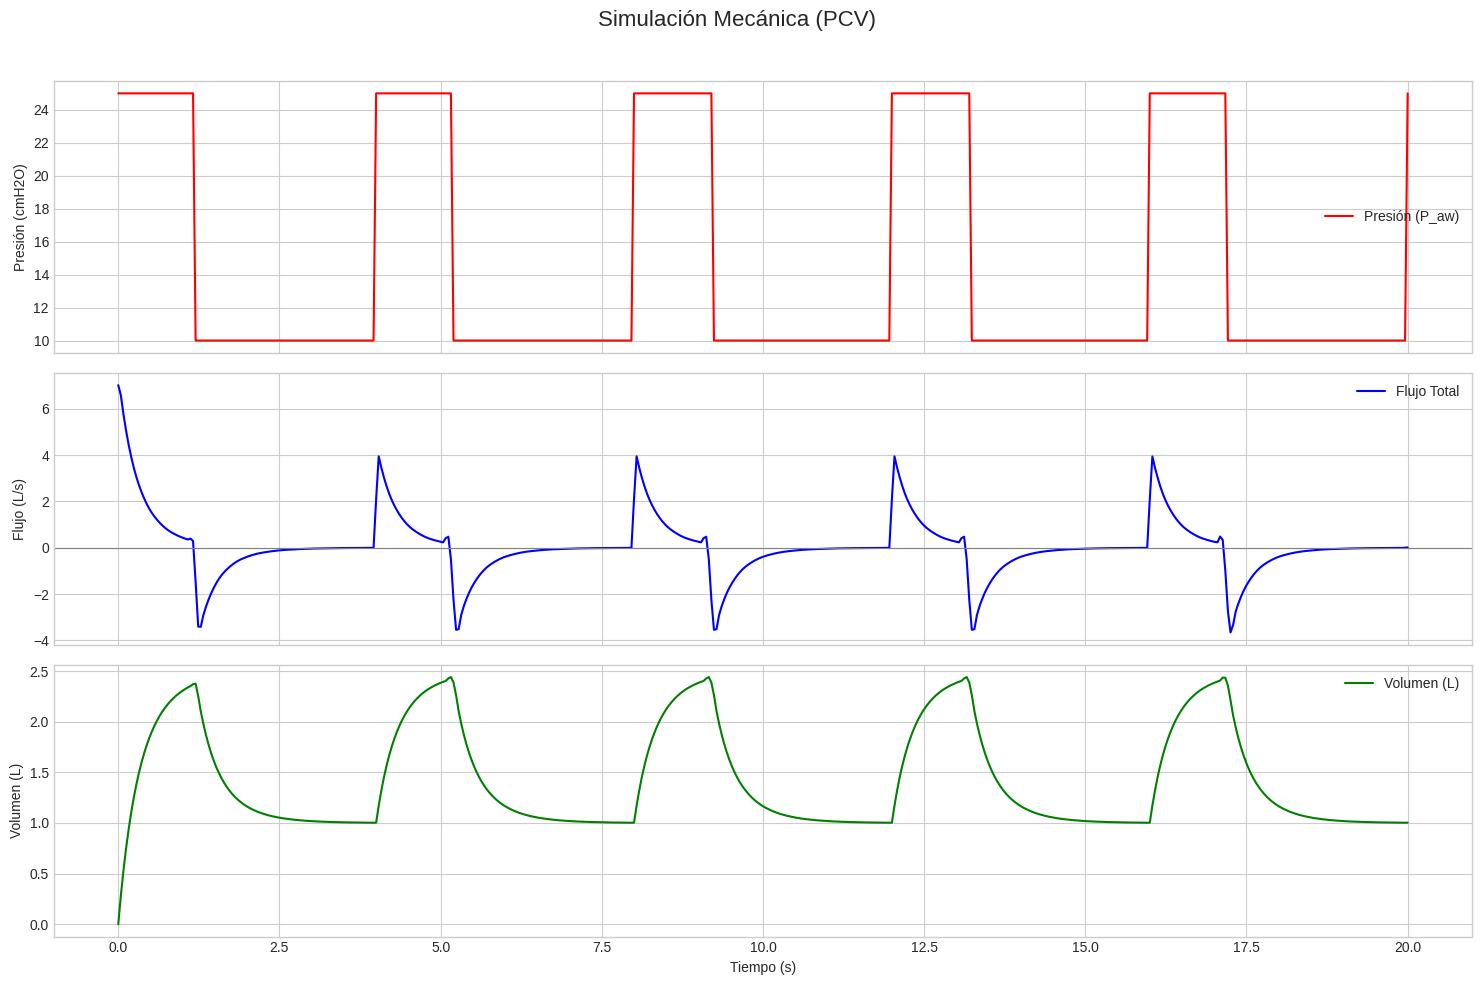

--- RESULTADOS DE LA SIMULACIÓN INTEGRAL ---

--- Parámetros del Ventilador ---
Modo: PCV, PEEP: 10.0 cmH2O, P_driving: 15.0 cmH2O, FR: 15.0/min

--- Resultados de Mecánica Ventilatoria (último ciclo) ---
Volumen Tidal (Vt) entregado: 2.44 L
Presión Pico: 25.0 cmH2O

--- Resultados de Intercambio Gaseoso ---
Ventilación Minuto Total (VE): 36.63 L/min
Ventilación Minuto Alveolar (VA): 34.38 L/min
Presión Alveolar de CO2 (PACO2): 0.0 mmHg
Presión Alveolar de O2 (PAO2): 205.2 mmHg

--- Resultados de Interacción Corazón-Pulmón ---
Presión Media en Vía Aérea (P_mean): 13.8 cmH2O
Gasto Cardíaco Basal: 5.5 L/min  -->  Gasto Cardíaco Actual: 4.94 L/min
PaO2 estimada: 195.2 mmHg
SaO2 estimada: 100.0%
Contenido Arterial de O2 (CAO2): 19.35 mL/dL
Entrega de Oxígeno a Tejidos (DO2): 955.2 mL/min
---------------------------------------------


/tmp/ipython-input-6-1709350389.py:88: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  area_bajo_curva = np.trapz(p_aw_ultimo_ciclo, t_ultimo_ciclo)


In [7]:
# 1. Definir el Paciente y el Ventilador
paciente_normal = Paciente(R1=5, C1=0.05, R2=10, C2=0.05)
# PCV con PEEP alto y un P_driving moderado
ventilador_pcv = Ventilador(modo='PCV', PEEP=10.0, P_driving=15.0, fr=15.0, Ti=1.2)

# 2. Módulo de Simulación Mecánica
simulador = Simulador(paciente_normal, ventilador_pcv)
t, V1, V2 = simulador.simular(num_ciclos=5, pasos_por_ciclo=100)
resultados_mecanica = simulador.procesar_resultados(t, V1, V2)

# Graficar los resultados de la mecánica
simulador.graficar_resultados(resultados_mecanica, "Simulación Mecánica (PCV)")

# 3. Módulo de Intercambio Gaseoso
# Parámetros fisiológicos para el intercambio
intercambio = IntercambioGases(
    ventilador=ventilador_pcv,
    V_D=0.150,      # Espacio muerto de 150 mL
    VCO2=0.2,       # Producción de CO2 de 200 mL/min
    R=0.8,          # Cociente respiratorio
    FiO2=0.40,      # FiO2 del 40%
    Pb=560.0        # Presión barométrica de Medellín (mmHg)
)
resultados_gases = intercambio.calcular(resultados_mecanica)

# 4. Módulo de Interacción Corazón-Pulmón
# Paciente con sensibilidad hemodinámica moderada (k=0.15)
cardio = InteraccionCorazonPulmon(
    GC_base_L_min=5.5,
    k_sensibilidad=0.15,
    hb_g_dl=14.0
)
resultados_cardio = cardio.calcular(resultados_mecanica, resultados_gases, ventilador_pcv)


# 5. Imprimir todos los resultados de forma organizada
print("--- RESULTADOS DE LA SIMULACIÓN INTEGRAL ---")
print("\n--- Parámetros del Ventilador ---")
print(f"Modo: {ventilador_pcv.modo}, PEEP: {ventilador_pcv.PEEP} cmH2O, P_driving: {ventilador_pcv.P_driving} cmH2O, FR: {ventilador_pcv.fr}/min")

print("\n--- Resultados de Mecánica Ventilatoria (último ciclo) ---")
vt_calculado = np.max(resultados_mecanica['Vt']) - np.min(resultados_mecanica['Vt'])
print(f"Volumen Tidal (Vt) entregado: {vt_calculado:.2f} L")
print(f"Presión Pico: {np.max(resultados_mecanica['P_aw']):.1f} cmH2O")

print("\n--- Resultados de Intercambio Gaseoso ---")
print(f"Ventilación Minuto Total (VE): {resultados_gases['VE_min']:.2f} L/min")
print(f"Ventilación Minuto Alveolar (VA): {resultados_gases['VA_min']:.2f} L/min")
print(f"Presión Alveolar de CO2 (PACO2): {resultados_gases['PACO2_mmHg']:.1f} mmHg")
print(f"Presión Alveolar de O2 (PAO2): {resultados_gases['PAO2_mmHg']:.1f} mmHg")

print("\n--- Resultados de Interacción Corazón-Pulmón ---")
print(f"Presión Media en Vía Aérea (P_mean): {resultados_cardio['P_mean_cmH2O']:.1f} cmH2O")
print(f"Gasto Cardíaco Basal: {cardio.GC_base_L_min} L/min  -->  Gasto Cardíaco Actual: {resultados_cardio['GC_actual_L_min']:.2f} L/min")
print(f"PaO2 estimada: {resultados_cardio['PaO2_mmHg']:.1f} mmHg")
print(f"SaO2 estimada: {resultados_cardio['SaO2_percent']:.1f}%")
print(f"Contenido Arterial de O2 (CAO2): {resultados_cardio['CAO2_ml_dl']:.2f} mL/dL")
print(f"Entrega de Oxígeno a Tejidos (DO2): {resultados_cardio['DO2_ml_min']:.1f} mL/min")
print("---------------------------------------------")